In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
from langchain_openai import ChatOpenAI
from os import getenv

llm = ChatOpenAI(
    model = "upstage/solar-pro-3:free",
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

response = llm.invoke('Hello')
print(response.content)

Hello! 👋 I'm Solar Open 100B, a large language model developed by Upstage. How can I assist you today? Feel free to ask about information, writing, coding, or anything else you’re curious about.


In [8]:
import requests

response = requests.post(
  "https://openrouter.ai/api/v1/embeddings",
  headers={
    "Authorization": f"Bearer {getenv('OPENROUTER_API_KEY')}",
    "Content-Type": "application/json",
  },
  json={
    "model": "openai/text-embedding-3-small",
    "input": "Hello world"
  }
)

data = response.json()
embedding = data["data"][0]["embedding"]
print(f"Embedding dimension: {len(embedding)}")


Embedding dimension: 1536


In [9]:
from typing import List, Any, TypedDict, Optional, Literal, Annotated, Sequence
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Markdown, Image
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage, BaseMessage, ToolMessage
from langgraph.graph.message import add_messages
from operator import add

In [10]:
class AgentState(TypedDict):
    mode : str
    num_of_q : int
    num_of_follow_up : int
    position : str
    evaluation_result: Annotated[str, add] = ''
    hr_report: Annotated[str, add] = ''
    company_name: str
    messages: Annotated[list, add_messages]

## *Recruiter Agent*

In [11]:
# Load a decument
pdf_path = "../utils/interview-llm-hoang.pdf"
resume_path = "../utils/Sudip_AI_Eng.pdf"

if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"File not found: {pdf_path}")

if not os.path.exists(resume_path):
    raise FileNotFoundError(f"File not found: {resume_path}")

In [12]:
from langchain_community.document_loaders import PyPDFLoader

pdf_loader = PyPDFLoader(pdf_path)
resume_loader = PyPDFLoader(resume_path)

# Checks if the PDF is there
try:
    pages = pdf_loader.load()
    resume = resume_loader.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
    print(f"Resume has been loaded and has {len(resume)} pages")
except Exception as e:
    print(f"Error loading PDFs: {e}")
    raise

PDF has been loaded and has 12 pages
Resume has been loaded and has 1 pages


In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Split pages to chunks
text_spliter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
page_chunks = text_spliter.split_documents(pages)
resume_chunks = text_spliter.split_documents(resume)

print(f"Document split into {len(page_chunks)} chunks")
print(f"Resume split into {len(resume_chunks)} chunks")

Document split into 27 chunks
Resume split into 4 chunks


In [14]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

pdf_vectorstore = Chroma.from_documents(
    documents=page_chunks,
    embedding=embedding,
    collection_name="interview-llm-hoang",
    persist_directory="./chroma_db/interview-llm"
)
resume_vectorstore = Chroma.from_documents(
    documents=resume_chunks,
    embedding=embedding,
    collection_name="sudip-ai-eng-resume",
    persist_directory="./chroma_db/sudip-ai-eng"
)

In [15]:
pdf_retriever = pdf_vectorstore.as_retriever(search_type="similarity")
resume_retriever = resume_vectorstore.as_retriever(search_type="similarity")

In [16]:
from langchain_core.tools.retriever import create_retriever_tool

pdf_tool = create_retriever_tool(
    retriever=pdf_retriever,
    name="interview_document_retriever",
    description="Useful for answering questions about the interview document."
)
resume_tool = create_retriever_tool(
    retriever=resume_retriever, 
    name="candidate_resume_retriever",
    description="Useful for answering questions about the candidate's resume."
)
tools = [pdf_tool, resume_tool]

In [17]:
from IPython.display import display, Markdown, Image

display(Markdown(create_retriever_tool.__doc__))

Create a tool to do retrieval of documents.

    Args:
        retriever: The retriever to use for the retrieval
        name: The name for the tool. This will be passed to the language model,
            so should be unique and somewhat descriptive.
        description: The description for the tool. This will be passed to the language
            model, so should be descriptive.
        document_prompt: The prompt to use for the document.
        document_separator: The separator to use between documents.
        response_format: The tool response format.

            If `"content"` then the output of the tool is interpreted as the contents of
            a `ToolMessage`. If `"content_and_artifact"` then the output is expected to
            be a two-tuple corresponding to the `(content, artifact)` of a `ToolMessage`
            (artifact being a list of documents in this case).

    Returns:
        Tool class to pass to an agent.
    

In [18]:
from langchain_core.prompts import PromptTemplate

interviewer_prompt = PromptTemplate(
    input_variables=["mode", "company_name", "position", "number_of_questions", "number_of_follow_up"],
    template="""
You are an {mode} AI interviewer for a leading tech company called {company_name}, conducting an interview for a {position} position.

Your goal is to assess the candidate's technical skills, problem-solving abilities, communication skills, and experience relevant to data science roles.

Maintain a professional yet approachable tone.

You have access to two tools:
1. `interview_document_retriever`: This tool can search a knowledge base of interview questions related to the {position} position. Use this tool to find relevant questions to ask the candidate.
2. `candidate_resume_retriever`: This tool can search the candidate's resume to find information about their past projects and experience. Use this tool to ask relevant projects from their resume like {position} projects.

Start by introducing yourself as the interviewer and asking the candidate to introduce themselves, then ask use tools to retrive a project of you choice in there resume and ask them about it.

Focus on questions related to the position and the candidate's resume.

You ask only one Introduction question at the beginning of the interview, then one question about a project from there resume then {number_of_questions} questions about the position from the knowledge base with {number_of_follow_up} flowup question only if there answer was too vage and incomplete.

If asked any irrelevant question, respond with: "Sorry, this is out of scope."

After the interview is finished you output: "Thank you, that's it for today."

if you use any tool print"tool used: `tool_name`"

when you pull a question from the knowledgebase specify the number of the question, Example:
`
  Question one: What challenges do LLMs face in deployment?
  Question twe: What defines a Large Language Model (LLM)?
`
to elustrate between main questions and follow-up questions.

Begin the interview now.
"""
)

In [19]:
def recruiter(state: AgentState) -> AgentState:
    '''the recruiter agent conducts interviews using the interviewer prompt and tools to assess candidates.'''
    sys_prompt = SystemMessage(content=interviewer_prompt.format(
        mode=state['mode'],
        company_name=state['company_name'],
        position=state['position'],
        number_of_questions=state['num_of_q'],
        number_of_follow_up=state['num_of_follow_up']
    ))
    all_messages = [sys_prompt] + state['messages']
    result = llm.bind_tools(tools).invoke(all_messages)
    return {"messages": [result]}

In [20]:
recruiter(AgentState(
    mode="friendly",
    num_of_q=1,
    num_of_follow_up=1,
    position="AI Engineer",
    company_name="Tech Innovators Inc.",
    messages=[HumanMessage(content="Hello, I am Sudip Das, I am an AI Engineer with 1 year of experience in building AI systems.")]
))['messages']

[AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1303, 'prompt_tokens': 787, 'total_tokens': 2090, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 1271, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 64}, 'cost': 0, 'is_byok': False, 'cost_details': {'upstream_inference_cost': 0, 'upstream_inference_prompt_cost': 0, 'upstream_inference_completions_cost': 0}}, 'model_provider': 'openai', 'model_name': 'upstage/solar-pro-3:free', 'system_fingerprint': None, 'id': 'gen-1769682499-Aqtjec6pRKjqVponApMM', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c094b-f4bf-7241-8634-5f110f08de56-0', tool_calls=[{'name': 'candidate_resume_retriever', 'args': {'query': 'AI Engineer projects from past year'}, 'id': 'caaqg6qqaa', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 787, 'out

## *Evaluator Agent*

In [22]:
from langchain_openai import ChatOpenAI
from os import getenv

evallm = ChatOpenAI(
    model = "upstage/solar-pro-3:free",
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

response = evallm.invoke('Hello')
print(response.content)

Hello! 👋  

I’m **Solar Open 100B**, a large‑language model built by **Upstage**, a Korean AI startup. I’m trained on data up to July 2025 and can help you with:

- **Korean & English** writing, brainstorming, and editing  
- **Summarizing**, **extracting key points**, and **answering questions**  
- **Code generation**, debugging, and explanations for many programming languages  
- **Logical reasoning**, problem‑solving, and data‑analysis insights  
- **Creative tasks** such as story ideas, marketing copy, or game concepts  

Feel free to let me know what you need—whether it’s a quick answer, a detailed explanation, or something more elaborate. I’m here to assist!


In [23]:
evaluator_prompt = PromptTemplate(
    input_variables=["num_of_q", "num_of_follow_up", "position"],
    template="""You are an AI evaluator for a job interview. Your task is to evaluate the candidate's responses based\\
    on their relevance, clarity, and depth.
    You will receive one Introduction question, one project question, and {num_of_q} technical questions with up to {num_of_follow_up} follow up questions\\
    about {position} position.
    Ignore any irrelevant questions or answers.
    You evaluate each response with a score from 1 to 10, where 1 is the lowest and 10 is the highest.
    The context of the interview is as follows:
        Introduction question:
        Project question:
        Technical questions:
    each question could have a follow-up question, if so you should evaluate the main question only and assume the follow up answer is appended to the main answer.
    Usually the main technical question is in the following format:
        Question one: Example question one?
        Question two: Example question two?
    you should evaluate the main question only and assume the follow up answer is appended to the main answer.
    If you don't have enough information to evaluate a Technical question, use the tool `interview_document_retriever` to get more information about the question.
    You should output the evaluation in the following format:
    Evaluation:
        1. Introduction question: [score] - [reasoning]
        2. Project question: [score] - [reasoning]
        3. Technical question one: [score] - [reasoning]
        4. Technical question two: [score] - [reasoning]
    """)

In [24]:
def evaluator(state: AgentState) -> AgentState:
    '''the evaluator agent assesses candidate responses using the evaluator prompt.'''
    sys_prompt = evaluator_prompt.format(
        num_of_q=state['num_of_q'],
        num_of_follow_up=state['num_of_follow_up'],
        position=state['position']
    )
    sys_msg = SystemMessage(content=sys_prompt)
    interview_base = []
    for msg in state['messages']:
        if isinstance(msg, HumanMessage):
            interview_base.append('Candidate: ' + str(msg.content))
        elif isinstance(msg, AIMessage):
            interview_base.append('Interviewer: ' + str(msg.content))
    
    all_messages = [sys_msg, HumanMessage(content='\n'.join(interview_base))]
    evallm_with_tools = evallm.bind_tools([pdf_tool])
    results = evallm_with_tools.invoke(all_messages)
    return {'messages': [AIMessage(content=results.content)], 
            'evaluation_result': results.content}

In [25]:
def custom_tools_condition(state: AgentState):
    last_message = state['messages'][-1] if state['messages'] else None
    if last_message is None:
        return 'WAIT_FOR_HUMAN'
    if isinstance(last_message, AIMessage) and hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    elif isinstance(last_message, AIMessage) and 'that\'s it for today' in last_message.content.lower():
        return "END_CONVERSATION"
    else:
        return 'WAIT_FOR_HUMAN'

## *Report Writer*

In [26]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER, TA_LEFT
from langchain_core.tools import tool
import os

In [27]:
@tool
def save_report_as_pdf(report_content: str, filename: str) -> str:
    """
    Saves the provided report content as a PDF file.

    Args:
        report_content (str): The full text content of the HR report.
        filename (str): The desired name for the PDF file (e.g., "HR_Interview_Report_CandidateX.pdf").
                        Do NOT include path, just the filename. The file will be saved in the current directory.

    Returns:
        str: The full path to the saved PDF file if successful, otherwise an error message.
    """
    if not filename.endswith(".pdf"):
        filename += ".pdf"
    
    safe_filename = os.path.basename(filename)

    try:
        doc = SimpleDocTemplate(safe_filename, pagesize=letter)
        styles = getSampleStyleSheet()
        
        # --- MODIFIED PART START ---
        # Use existing styles or create new ones by copying and modifying,
        # rather than trying to add names that already exist.

        # Example: Use 'h1' for main title, 'h2' for section titles, 'Normal' for body text.
        # You can adjust attributes of these copied styles if needed.
        
        # Adjust 'h1' for center alignment (it's usually left by default)
        h1_style = styles['h1']
        h1_style.alignment = TA_CENTER
        h1_style.spaceAfter = 14 # Add some space after the heading

        # Adjust 'h2' for left alignment (it's usually left by default)
        h2_style = styles['h2']
        h2_style.alignment = TA_LEFT
        h2_style.spaceAfter = 8 # Add some space after the subheading

        # Use 'Normal' style for body text
        body_style = styles['Normal']
        body_style.spaceAfter = 6 # Small space after body paragraphs

        # --- MODIFIED PART END ---

        story = []
        
        # Add a title
        story.append(Paragraph("HR Interview Report", h1_style))
        story.append(Spacer(1, 0.2 * letter[1])) # Add some space

        # Split the report content into paragraphs, preserving newlines
        paragraphs = report_content.split('\n\n')
        
        for para_text in paragraphs:
            if para_text.strip(): # Avoid empty paragraphs
                # Check for specific section headings from your prompt's expected output
                if para_text.strip().startswith((
                    'Candidate\'s Overall Suitability:',
                    'Strengths:',
                    'Areas for Development/Weaknesses:',
                    'Key Technical Skills Demonstrated:',
                    'Problem-Solving Approach:',
                    'Communication Skills:',
                    'Relevant Experience Highlights:',
                    'Recommendations:'
                )):
                    story.append(Paragraph(para_text, h2_style)) # Use h2 style for sections
                else:
                    story.append(Paragraph(para_text, body_style)) # Use Normal style for body content
                story.append(Spacer(1, 0.1 * letter[1])) # Add a small space after each paragraph

        doc.build(story)
        return f"Report successfully saved to: {os.path.abspath(safe_filename)}"
    except Exception as e:
        # It's good to print the full traceback for debugging during development
        import traceback
        traceback.print_exc()
        return f"Error saving report as PDF: {e}"

# Make sure this tool is available to your report_writer_llm
report_writer_tools = [save_report_as_pdf]

In [28]:
report_writer_prompt = PromptTemplate(
    input_variables=["position", "company_name", "interview_transcript", "evaluation_report"],
    template="""You are an AI HR Report Writer. Your task is to synthesize information from a job interview transcript and its evaluation into a concise, professional report for Human Resources at {company_name}.

The interview was for a **{position}** position.

Your report should focus on key takeaways relevant to HR's decision-making, including but not limited to:
-   **Candidate's Overall Suitability:** A brief summary of whether the candidate seems suitable for the role based on their performance.
-   **Strengths:** Specific areas where the candidate performed well, supported by examples from the transcript if clear.
-   **Areas for Development/Weaknesses:** Specific areas where the candidate struggled or showed gaps, supported by examples from the transcript if clear.
-   **Key Technical Skills Demonstrated:** List any core technical skills (e.g., Python, SQL, ML algorithms, data analysis, specific frameworks) explicitly mentioned or clearly demonstrated by the candidate's answers.
-   **Problem-Solving Approach:** Insights into how the candidate approaches technical problems or challenges (if discernible).
-   **Communication Skills:** Assessment of clarity, conciseness, and overall effectiveness of their communication during the interview.
-   **Relevant Experience Highlights:** Any particularly relevant past projects or experiences highlighted by the candidate.
-   **Recommendations (Optional):** A high-level recommendation (e.g., "Proceed to next round," "Consider for a different role," "Not a good fit at this time").

You will be provided with:
1.  **Full Interview Transcript:** The complete conversation between the recruiter and the candidate.
2.  **Evaluation Report:** A structured evaluation of the candidate's responses provided by an AI evaluator, including scores and reasoning for each question.

**Instructions for Report Generation:**
-   **Conciseness:** Be brief and to the point. HR personnel have limited time.
-   **Professional Tone:** Maintain a neutral, objective, and professional tone throughout the report.
-   **Evidence-Based:** Support your points with specific references or inferences from the provided transcript and evaluation. Do NOT invent information.
-   **Structure:** Organize your report with clear headings for each section (e.g., "Candidate Summary," "Strengths," "Areas for Development," etc.).
-   **Format:** Present the report as a single, well-formatted text block. Do not include any conversational filler.
-   **Tool Usage:** After generating the report, you MUST use the `save_report_as_pdf` tool to save the report to a file. Choose a descriptive filename like "Interview_Report_{company_name}_{position}.pdf".
    * Example Tool Call: `tool_code: print(save_report_as_pdf(report_content="[Your generated report text]", filename="Interview_Report_JaneDoe_DataScientist.pdf"))`

---
**Interview Transcript:**
{interview_transcript}

---
**Evaluation Report:**
{evaluation_report}

Dont forget to save the report in a pdf using `save_report_as_pdf` tool.
"""
)

In [29]:
def report_writer(state: AgentState) -> AgentState:
    """ Generates a report based on the interview transcript and evaluation """
    interviewer_transcript = []
    for m in state["messages"]:
        if isinstance(m, HumanMessage):
            interviewer_transcript.append('Candidate: ' + str(m.content))
        elif isinstance(m, AIMessage):
            if 'Evaluation:\n1. Introduction question' not in m.content:
                interviewer_transcript.append('AI Recruiter: ' + str(m.content))
    
    evaluation_report = [m.content for m in state["messages"] if isinstance(m, AIMessage) and 'Evaluation:\n1. Introduction question' in m.content]
    sys_prompt = report_writer_prompt.format(
        position=state['position'],
        company_name=state['company_name'],
        interview_transcript= '\n'.join(interviewer_transcript),
        evaluation_report=evaluation_report
    )
    sys_message = SystemMessage(content=sys_prompt)
    all_messages = [sys_message, HumanMessage(content='Generate the report now.')]
    result = llm.bind_tools(report_writer_tools).invoke(all_messages)
    return {"messages": [result], "hr_report": result.content}

In [30]:
display(Markdown(report_writer.__doc__))

 Generates a report based on the interview transcript and evaluation 

## *LangGraph Workflow*

In [31]:
from langgraph.prebuilt import ToolNode, tools_condition

In [32]:
# -------------- Nodes ---------------
# Define the graph
workflow = StateGraph(AgentState)

# Add the agent node
workflow.add_node("recruiter", recruiter)

# Add tool node
tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)

# Add the evaluator node
workflow.add_node("evaluator", evaluator)

# Add evaluator tool node
evaluator_tool_node = ToolNode([pdf_tool])
workflow.add_node("evaluator_tools", evaluator_tool_node)

# Add report writer node
workflow.add_node("report_writer", report_writer)

# Add the save report tool node
report_writer_tool_node = ToolNode([save_report_as_pdf])
workflow.add_node("report_writer_tools", report_writer_tool_node)

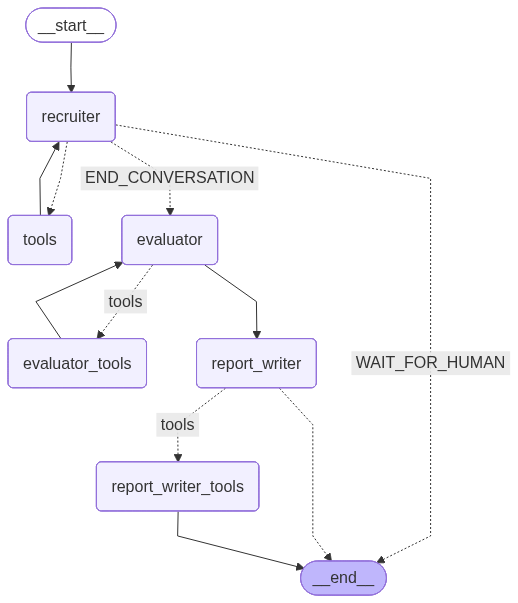

In [33]:
# ---------------- Work flow -------------------
# Set the entry point
workflow.set_entry_point("recruiter")

# For now, let's assume the agent will either call a tool or finish
workflow.add_conditional_edges(
    "recruiter",
    custom_tools_condition,
    {
        "tools": "tools",  # If tools are called, go to the tools node
        "END_CONVERSATION": "evaluator",  # If conversation ends, go to evaluator
        "WAIT_FOR_HUMAN": END  # If waiting for human, go to end
    }
)

# Add edge from tools back to the recruiter
workflow.add_edge("tools", "recruiter")

# Add edge from evaluator tools to evaluator
workflow.add_edge("evaluator_tools", "evaluator")

# Define edges for evaluator node
workflow.add_conditional_edges(
    "evaluator",
    tools_condition,
    {
        "tools": "evaluator_tools",  
        END: "report_writer"
    }
)
# Add edge from evaluator to report writer
workflow.add_edge("evaluator", "report_writer")

# Define edges for report writer node
workflow.add_conditional_edges(
    "report_writer",
    tools_condition,
    {
        "tools": "report_writer_tools",  
        END: END
    }
)
# Compile the graph
app = workflow.compile()
app

In [34]:
def chat_loop(initial_state: AgentState):
    curr_state = initial_state.copy()
    print("""Starting chat loop... 
          Type 'exit' or 'quit' to end.""")
    
    first_out = app.invoke(curr_state)
    # Don't use update - directly replace the state with the output
    curr_state = first_out
    ai_message = first_out['messages'][-1]
    if isinstance(ai_message, AIMessage):
        print(f'Recruiter:\n')
        ai_message.pretty_print()
        if 'that\'s it for today' in ai_message.content.lower():
            print("Conversation ended by Recruiter.")
            return curr_state
    
    while True:
        user_input = input("You: ")
        if user_input.lower() in ['exit', 'quit']:
            print("Exiting chat.")
            break
        
        # Create a new input state with the human message added
        input_state = {
            **curr_state,
            'messages': curr_state['messages'] + [HumanMessage(content=user_input)]
        }
        
        try:
            result = app.invoke(input_state)
            # Replace state entirely instead of updating
            curr_state = result
        except Exception as e:
            print(f"Error during invocation: {e}")
            import traceback
            traceback.print_exc()
            continue
            
        ai_message = result['messages'][-1]
        if isinstance(ai_message, AIMessage):
            print(f'Recruiter:\n')
            ai_message.pretty_print()
            if 'that\'s it for today' in ai_message.content.lower():
                print("Conversation ended by Recruiter.")
                break
        elif isinstance(ai_message, ToolMessage):
            print(f'Recruiter used tool: {ai_message.name}')
            ai_message.pretty_print()
        else:
            print(f"AI Recruiter (Other Message Type): \n")
            ai_message.pretty_print()
        
    return curr_state

In [106]:
initial_state = {
    "mode": "friendly",
    "num_of_q": 1,
    "num_of_follow_up": 1,
    "position": "AI Engineer",
    "company_name": "Data Solutions Inc.",
    "messages": [HumanMessage(content="Hi")],
    "evaluation_result": "",
    "hr_report": ""
}
# Start the chat loop
final_state = chat_loop(initial_state)

Starting chat loop... 
          Type 'exit' or 'quit' to end.
Recruiter:

================================== Ai Message ==================================

Hello! I'm your interviewer today from Data Solutions Inc. We're excited to have you here. To start, could you please introduce yourself briefly?
Recruiter:

================================== Ai Message ==================================

tool used: `candidate_resume_retriever`

Thank you for the introduction! I noticed your project "Multimodal-RAG-Forge" on your resume. Could you tell me more about the challenges you faced while building this multimodal RAG and OCR-based summarization system and how you overcame them?
Recruiter:

================================== Ai Message ==================================

tool used: `interview_document_retriever`

Question one: What challenges do LLMs face in deployment?

Question two: How does the attention mechanism function in transformer models?
Recruiter:

==============================

In [107]:
final_state

{'mode': 'friendly',
 'num_of_q': 1,
 'num_of_follow_up': 1,
 'position': 'AI Engineer',
 'evaluation_result': 'Evaluation:\n1. **Introduction question: 9/10** - The candidate provided a clear and concise introduction, highlighting their academic background, relevant skills (Linear Algebra, Optimization), and practical experience (internship at Unihox). They also mentioned their passion for AI and a specific project, demonstrating alignment with the role.\n\n2. **Project question: 9/10** - The candidate explained the challenges faced in the "Multimodal-RAG-Forge" project in detail, including technical solutions like modular pipelines, custom caching, and handling latency. Their response demonstrated problem-solving skills and a deep understanding of the project.\n\n3. **Technical question one (Challenges in LLM deployment): 8/10** - The candidate addressed key challenges such as computational costs, latency, reliability, and data security. They also tied their response to real-world so

# **Sound System**

In [35]:
class AgentState(TypedDict):
    mode: str
    num_of_q: int
    num_of_follow_up: int
    position: str
    evaluation_result: str | None
    company_name: str
    messages: Annotated[list, add_messages]

### **TTS with gtts**

In [60]:
from elevenlabs import ElevenLabs
from IPython.display import Audio
import os
from dotenv import load_dotenv

load_dotenv()


# Initialize the ElevenLabs client
client = ElevenLabs(
  api_key=os.getenv("ELEVENLABS_API_KEY"),
)

# Text to convert
text = "This is ElevenLabs text to speech running on Google Colab."

# Generate speech (returns a generator)
audio_stream = client.text_to_speech.convert(
    text=text,
    voice_id="JBFqnCBsd6RMkjVDRZzb",
    model_id="eleven_multilingual_v2",
    output_format="mp3_44100_128",
)
# Save to a file by iterating through the generator
with open("out.mp3", "wb") as f:
    for chunk in audio_stream:
        f.write(chunk)

# Play in notebook
Audio("out.mp3", autoplay=True)

ApiError: headers: {'date': 'Thu, 29 Jan 2026 11:30:59 GMT', 'server': 'uvicorn', 'content-length': '476', 'content-type': 'application/json', 'access-control-allow-origin': '*', 'access-control-allow-headers': '*', 'access-control-allow-methods': 'POST, PATCH, OPTIONS, DELETE, GET, PUT', 'access-control-max-age': '600', 'strict-transport-security': 'max-age=1800;', 'x-trace-id': '0ef2054edfd70d97207f6d65958bb2af', 'x-region': 'asia-southeast1', 'via': '1.1 google', 'alt-svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'}, status_code: 401, body: {'detail': {'status': 'detected_unusual_activity', 'message': 'Unusual activity detected. Free Tier usage disabled. If you are using a proxy/VPN you might need to purchase a Paid Plan to not trigger our abuse detectors. Free Tier only works if users do not abuse it, for example by creating multiple free accounts. If we notice that many people try to abuse it, we will need to reconsider Free Tier altogether. \nPlease play fair and purchase any Paid Subscription to continue.'}}

In [37]:
# Install: pip install gtts playsound
from gtts import gTTS
import os
import tempfile

def speak_text(text: str):
    """Convert text to speech using Google TTS"""
    tts = gTTS(text=text, lang='en')
    with tempfile.NamedTemporaryFile(delete=False, suffix='.mp3') as fp:
        temp_path = fp.name
    tts.save(temp_path)
    
    # Play using system default player on Windows
    os.system(f'start {temp_path}')

In [ ]:
# Test it
speak_text("The first move is what sets everything in motion.")

In [38]:
def chat_loop(initial_state: AgentState):
    curr_state = initial_state.copy()
    print("""Starting chat loop... 
          Type 'exit' or 'quit' to end.""")
    
    first_out = app.invoke(curr_state)
    # Don't use update - directly replace the state with the output
    curr_state = first_out
    ai_message = first_out['messages'][-1]
    if isinstance(ai_message, AIMessage):
        print(f'Recruiter:\n')
        ai_message.pretty_print()
        speak_text(ai_message.content)
        if 'that\'s it for today' in ai_message.content.lower():
            print("Conversation ended by Recruiter.")
            return curr_state
    
    while True:
        user_input = input("You: ")
        if user_input.lower() in ['exit', 'quit']:
            print("Exiting chat.")
            break
        
        # Create a new input state with the human message added
        input_state = {
            **curr_state,
            'messages': curr_state['messages'] + [HumanMessage(content=user_input)]
        }
        
        try:
            result = app.invoke(input_state)
            # Replace state entirely instead of updating
            curr_state = result
        except Exception as e:
            print(f"Error during invocation: {e}")
            import traceback
            traceback.print_exc()
            continue
            
        ai_message = result['messages'][-1]
        if isinstance(ai_message, AIMessage):
            print(f'Recruiter:\n')
            ai_message.pretty_print()
            speak_text(ai_message.content)
            if 'that\'s it for today' in ai_message.content.lower():
                print("Conversation ended by Recruiter.")
                break
        elif isinstance(ai_message, ToolMessage):
            print(f'Recruiter used tool: {ai_message.name}')
            ai_message.pretty_print()
        else:
            print(f"AI Recruiter (Other Message Type): \n")
            ai_message.pretty_print()
        
    return curr_state

In [31]:
initial_state = {
    "mode": "friendly",
    "num_of_q": 1,
    "num_of_follow_up": 1,
    "position": "AI Engineer",
    "company_name": "Data Solutions Inc.",
    "messages": [HumanMessage(content="Hi")],
    "evaluation_result": "",
    "hr_report": ""
}
# Start the chat loop
final_state = chat_loop(initial_state)

Starting chat loop... 
          Type 'exit' or 'quit' to end.
Recruiter:

================================== Ai Message ==================================

Hello! I'm your interviewer today from Data Solutions Inc. We're excited to have you here. To start, could you please introduce yourself briefly?
Recruiter:

================================== Ai Message ==================================

Thank you for the introduction, Sudip. I see you've worked on an interesting project called "Multimodal-RAG-Forge." Could you tell me more about this project? Specifically, what challenges did you face while building this system, and how did you overcome them?

tool used: `candidate_resume_retriever`

tool used: `interview_document_retriever`
Recruiter:

================================== Ai Message ==================================

Thank you for the overview. Let's dive deeper into your experience with LLMs.

Question one: What challenges do LLMs face in deployment?

tool used: `interview_docu

### **STT Implementation**

In [39]:
import sounddevice as sd

print("Available Microphones:")
devices = sd.query_devices()
for i, device in enumerate(devices):
    if device['max_input_channels'] > 0:
        print(f"{i}: {device['name']}")

Available Microphones:
0: Microsoft Sound Mapper - Input
1: Microphone Array (Intel® Smart 
4: Primary Sound Capture Driver
5: Microphone Array (Intel® Smart Sound Technology for Digital Microphones)
9: Microphone Array (Intel® Smart Sound Technology for Digital Microphones)
10: Stereo Mix (Realtek HD Audio Stereo input)
11: Microphone (Realtek HD Audio Mic input)
14: PC Speaker (Realtek HD Audio 2nd output with SST)
17: PC Speaker (Realtek HD Audio output with SST)
18: Microphone Array 1 ()
19: Microphone Array 2 ()
20: Microphone Array 3 ()
21: Microphone Array 4 ()


In [40]:
import whisper
import sounddevice as sd
import soundfile as sf
import tempfile

In [41]:
print("Initializing Whisper model...")
model_root = "./whisper_models"
os.makedirs(model_root, exist_ok=True)

global_model = whisper.load_model("base", download_root=model_root)
print("Model loaded and ready.")

def record_and_transcribe(duration=5, fs=16000, device=None, model=global_model):
    """
    Records audio and transcribes.
    Uses the pre-loaded 'model' to avoid disk-reading delays.
    """
    print("Recording...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, device=device)
    sd.wait()  
    print("Recording complete.")
    
    # Save to a temporary WAV file
    with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as fp:
        temp_wav_path = fp.name
        sf.write(temp_wav_path, recording, fs)
    
    print("Transcribing audio...")
    result = model.transcribe(temp_wav_path)
    transcription = result['text']
    
    # Clean up
    os.remove(temp_wav_path)
    
    print(f"Transcription: {transcription}")
    return transcription

Initializing Whisper model...
Model loaded and ready.


In [30]:
record_and_transcribe()

Recording...
Recording complete.
Transcribing audio...
Transcription:  Hi, I am Sudhiddas. Currently I am studying at IIT ISN Thanbad.


' Hi, I am Sudhiddas. Currently I am studying at IIT ISN Thanbad.'

In [42]:
import pyaudio # Capture microphone audio
import websocket # Real-time streaming to AssemblyAI
import json
import threading # Run audio streaming & websocket in parallel
import time
import wave
from urllib.parse import urlencode # Build WebSocket query params
from datetime import datetime
import os
import assemblyai as aai

In [43]:
ASSEMBLYAI_API_KEY = os.getenv("ASSEMBLYAI_API_KEY")
CONNECTION_PARAMS = {
    "sample_rate": 16000,
    "format_turns": True,
}
# Audio configuration
API_ENDPOINT_BASE_URL = "wss://streaming.assemblyai.com/v3/ws"
API_ENDPOINT = f"{API_ENDPOINT_BASE_URL}?{urlencode(CONNECTION_PARAMS)}"
FRAMES_PER_BUFFER = 800
SAMPLE_RATE = 16000
CHANNELS = 1
FORMAT = pyaudio.paInt16

# Global variable to control streaming
audio = None
stream = None
ws_app = None
audio_thread = None
stop_event = threading.Event()

### Wbsoceket event handlers

In [45]:
def on_open(ws):
    print("WebSocket connection opened.")

    def stream_audio(*args):
        global stream
        try:
            # 1. Initialize the stream
            stream = audio.open(
                format=FORMAT,
                channels=CHANNELS,
                rate=SAMPLE_RATE,
                input=True,
                frames_per_buffer=FRAMES_PER_BUFFER
            )           
            print("Streaming started...")
            
            while not stop_event.is_set():
                data = stream.read(FRAMES_PER_BUFFER, exception_on_overflow=False)
                
                # 3. Send and catch potential socket errors
                try:
                    ws.send(data, websocket.ABNF.OPCODE_BINARY)
                except websocket.WebSocketConnectionClosedException:
                    print("Socket closed by server.")
                    break
                    
        except Exception as e:
            print(f"Error during streaming: {e}")
            
        finally:
            # 4. Reliable cleanup
            if stream:
                stream.stop_stream()
                stream.close()
            # or check if it's still open here.
            print("Audio streaming stopped.")

    # Start the thread
    audio_thread = threading.Thread(target=stream_audio, daemon=True)
    audio_thread.start()

In [46]:
def on_message(ws, message):
    try:
        data = json.loads(message)
        msg_type = data.get("type")
        
        if msg_type == "Begin":
            print("Transcription session has started.")
            session_id = data.get("id")
            expires_at = data.get("expires_at")
            print(f"Session ID: {session_id}, Expires at: {datetime.fromtimestamp(expires_at)}")
        
        elif msg_type == "Turn":
            print(f"Transcription Turn: {data.get('id')}")
            transcript = data.get('transcript', '')
            formatted = data.get('turn_is_formatted', False)
            if formatted:
                print(f"Transcript: {transcript} (Formatted: {formatted})")
            else:
                print(f'\r{transcript}', end='', flush=True)
                
        elif msg_type == "Termination":
            print("Transcription session has ended by server.")
            audio_duration = data.get("audio_duration_seconds", 0)
            session_duration = data.get("session_duration_seconds", 0)
            print(f"Audio Duration: {audio_duration} seconds. Session Duration: {session_duration} seconds.")
            stop_event.set()
            
    except json.JSONDecodeError:
        print("Received non-JSON message from server.")
    except Exception as e:
        print(f"Error processing message: {e}")

In [47]:
def on_error(ws, error):
    print(f"WebSocket error: {error}")
    stop_event.set()
    
def on_close(ws, close_status_code, close_msg):
    print(f"WebSocket connection closed: {close_status_code} - {close_msg}")

    # Ensure audio resources are released
    global stream, audio
    stop_event.set()  # Signal audio thread just in case it's still running
    if stream:
        if stream.is_active():
            stream.stop_stream()
        stream.close()
        stream = None
    if audio:
        audio.terminate()
        audio = None
    # Try to join the audio thread to ensure clean exit
    if audio_thread and audio_thread.is_alive():
        audio_thread.join(timeout=1.0)

In [48]:
def run():
    global audio, stream, ws_app
    audio = pyaudio.PyAudio()
    stop_event.clear()
    try:
        stream = audio.open(
            format=FORMAT,
            channels=CHANNELS,
            rate=SAMPLE_RATE,
            input=True,
            frames_per_buffer=FRAMES_PER_BUFFER
        )
        print('microphone is set up.')
        print('Speak now into your microphone... Press Ctrl+C to stop.')
    except Exception as e:
        print(f"Error initializing microphone: {e}")
        return
    
    # Create WebSocket app
    ws_app = websocket.WebSocketApp(
        API_ENDPOINT,
        header={"Authorization": ASSEMBLYAI_API_KEY},
        on_open=on_open,
        on_message=on_message,
        on_error=on_error,
        on_close=on_close
    )
    ws_thread = threading.Thread(target=ws_app.run_forever, daemon=True)
    ws_thread.start()
    
    try:
        start_time = time.time()
        max_duration = 30
        while not stop_event.is_set():
            if time.time() - start_time > max_duration:
                print("Max duration reached. Stopping...")
                stop_event.set()
                break
            time.sleep(0.1)
    except KeyboardInterrupt:
        print("Keyboard interrupt received. Stopping...")
        stop_event.set()
        if ws_app and ws_app.sock and ws_app.sock.connected:
            try:
                terminate_msg = json.dumps({"type": "Terminate"})
                print("Sending termination message to server...")
                ws_app.send(terminate_msg)
                time.sleep(5)  
            except Exception as e:
                print(f"Error sending termination message: {e}")
                
        if ws_app:
            ws_app.close()
        ws_thread.join(timeout=2.0)
    except Exception as e:
        print(f"Unexpected error: {e}")
    finally:
        # Final cleanup
        if stream:
            if stream.is_active():
                stream.stop_stream()
            stream.close()
        if audio:
            audio.terminate()
        print("Program terminated.")

In [61]:
if __name__ == "__main__":
    run()

microphone is set up.
Speak now into your microphone... Press Ctrl+C to stop.
WebSocket connection opened.
Transcription session has started.
Session ID: 1ef493a3-bd69-4fa8-92b9-e9e702c9f4a7, Expires at: 2026-01-29 16:21:22
Streaming started...
Transcription Turn: None
Transcription Turn: None
hiTranscription Turn: None
hi iTranscription Turn: None
hi i amTranscription Turn: None
hi i amTranscription Turn: None
hi i amTranscription Turn: None
hi i amTranscription Turn: None
hi i am sudeepTranscription Turn: None
hi i am sudeepTranscription Turn: None
hi i am sudeep dasTranscription Turn: None
hi i am sudeep das currentlyTranscription Turn: None
hi i am sudeep das currently iTranscription Turn: None
hi i am sudeep das currently i amTranscription Turn: None
hi i am sudeep das currently i am livingTranscription Turn: None
hi i am sudeep das currently i am living inTranscription Turn: None
hi i am sudeep das currently i am living inTranscription Turn: None
hi i am sudeep das currently i am

: 

In [49]:
def start_realtime_stt(api_key: str):
    """
    Starts real-time STT using AssemblyAI WebSocket API and mic input.

    Press Ctrl+C to stop.
    """
    # --- Config ---
    CONNECTION_PARAMS = {
        "sample_rate": 16000,
        "format_turns": True,
    }
    API_ENDPOINT = f"wss://streaming.assemblyai.com/v3/ws?{urlencode(CONNECTION_PARAMS)}"
    FRAMES_PER_BUFFER = 800
    SAMPLE_RATE = 16000
    CHANNELS = 1
    FORMAT = pyaudio.paInt16

    # --- Globals ---
    stop_event = threading.Event()
    audio = pyaudio.PyAudio()
    stream = None
    ws_app = None

    # --- Callbacks ---
    def on_open(ws):
        def send_audio():
            while not stop_event.is_set():
                try:
                    audio_data = stream.read(FRAMES_PER_BUFFER, exception_on_overflow=False)
                    ws.send(audio_data, websocket.ABNF.OPCODE_BINARY)
                except Exception as e:
                    print(f"Error streaming: {e}")
                    break
        threading.Thread(target=send_audio, daemon=True).start()
        print("Microphone streaming started...")

    def on_message(ws, message):
        data = json.loads(message)
        if data.get("type") == "Turn":
            transcript = data.get("transcript", "")
            if data.get("turn_is_final", False):
                print(f"\nFinal Transcript: {transcript}")
            else:
                print(f"\rPartial: {transcript}", end="")

    def on_error(ws, error):
        print(f"WebSocket error: {error}")
        stop_event.set()

    def on_close(ws, code, msg):
        print(f"\nWebSocket closed: {code} - {msg}")
        stop_event.set()
        if stream:
            if stream.is_active():
                stream.stop_stream()
            stream.close()
        audio.terminate()

    # --- Setup ---
    try:
        stream = audio.open(
            input=True,
            frames_per_buffer=FRAMES_PER_BUFFER,
            channels=CHANNELS,
            format=FORMAT,
            rate=SAMPLE_RATE,
        )
        print("🎧 Microphone ready.")
    except Exception as e:
        print(f"Mic error: {e}")
        audio.terminate()
        return

    ws_app = websocket.WebSocketApp(
        API_ENDPOINT,
        header={"Authorization": api_key},
        on_open=on_open,
        on_message=on_message,
        on_error=on_error,
        on_close=on_close,
    )

    ws_thread = threading.Thread(target=ws_app.run_forever, daemon=True)
    ws_thread.start()

    try:
        while ws_thread.is_alive():
            time.sleep(0.1)
    except KeyboardInterrupt:
        print("\nStopping...")
        stop_event.set()
        if ws_app and ws_app.sock and ws_app.sock.connected:
            ws_app.send(json.dumps({"type": "Terminate"}))
        ws_app.close()
        ws_thread.join()
        print("Shutdown complete.")

In [50]:
start_realtime_stt(api_key=os.getenv("ASSEMBLYAI_API_KEY"))

🎧 Microphone ready.
Microphone streaming started...
Partial: Currently I am looking for a job in AI Engineering.
Stopping...

WebSocket closed: None - None
Shutdown complete.


In [52]:
import speech_recognition as sr

print("Available Microphones and Speakers:")
for index, name in enumerate(sr.Microphone.list_microphone_names()):
    print(f"{index}: {name}")

Available Microphones and Speakers:
0: Microsoft Sound Mapper - Input
1: Microphone Array (IntelÂ® Smart 
2: Microsoft Sound Mapper - Output
3: Speaker (Realtek(R) Audio)
4: Primary Sound Capture Driver
5: Microphone Array (IntelÂ® Smart Sound Technology for Digital Microphones)
6: Primary Sound Driver
7: Speaker (Realtek(R) Audio)
8: Speaker (Realtek(R) Audio)
9: Microphone Array (IntelÂ® Smart Sound Technology for Digital Microphones)
10: Stereo Mix (Realtek HD Audio Stereo input)
11: Microphone (Realtek HD Audio Mic input)
12: Headphones 1 (Realtek HD Audio 2nd output with SST)
13: Headphones 2 (Realtek HD Audio 2nd output with SST)
14: PC Speaker (Realtek HD Audio 2nd output with SST)
15: Speakers 1 (Realtek HD Audio output with SST)
16: Speakers 2 (Realtek HD Audio output with SST)
17: PC Speaker (Realtek HD Audio output with SST)
18: Microphone Array 1 ()
19: Microphone Array 2 ()
20: Microphone Array 3 ()
21: Microphone Array 4 ()


In [53]:
# test microphone
def test_microphone():
    r = sr.Recognizer()
    try:
        with sr.Microphone(device_index=1) as source:
            print("Testing microphone. Please say something...")
            r.adjust_for_ambient_noise(source, duration=1)
            audio = r.listen(source, timeout=10)
        try:
            text = r.recognize_google(audio)
            print(f"Microphone is working! You said: {text}")
        except sr.UnknownValueError:
            print("Microphone is working, but could not understand the audio.")
        except sr.RequestError as e:
            print(f"Microphone is working, but could not request results; {e}")
    except Exception as e:
        print(f"Microphone test failed: {e}")

test_microphone()

Testing microphone. Please say something...
Microphone is working! You said: hi I am Sude


### **Integration AssymbleAI STT to chat_loop**

In [57]:
import sounddevice as sd
import numpy as np
import tempfile
import requests
import time
from scipy.io.wavfile import write as write_wav

ASSEMBLYAI_API_KEY = os.getenv("ASSEMBLYAI_API_KEY")

In [64]:
def assemblyai_transcribe(duration=5, sample_rate=16000):
    print(f"Recording for {duration} seconds...")

    # Record audio
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate,
                   channels=1, dtype='int16')
    sd.wait()
    print("Recording done.")
    
    # Save to a temporary WAV file
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        write_wav(tmp.name, sample_rate, audio)
        audio_path = tmp.name
    print(f"Audio saved to {audio_path}. Uploading to AssemblyAI...")
    
    # Upload audio file
    headers = {"authorization": ASSEMBLYAI_API_KEY}
    with open(audio_path, "rb") as f:
        upload_resp = requests.post("https://api.assemblyai.com/v2/upload", headers=headers, data=f)
        
    if upload_resp.status_code != 200:
        print(f"Upload failed: {upload_resp.text}")
        return
    upload_url = upload_resp.json()['upload_url']
    print(f"Upload successful. URL: {upload_url}")
    
    # Request transcription
    transcript_resp = requests.post(
        "https://api.assemblyai.com/v2/transcript",
        headers=headers,
        json={"audio_url": upload_url}
    )
    if transcript_resp.status_code != 200:
        print(f"Transcription request failed: {transcript_resp.text}")
        return
    transcript_id = transcript_resp.json()['id']
    print(f"Transcription requested. ID: {transcript_id}. Polling for result ...")
    
    # Poll for result
    while True:
        status_resp = requests.get(
            f"https://api.assemblyai.com/v2/transcript/{transcript_id}", 
            headers=headers
        )
        status_data = status_resp.json()
        if status_data['status'] == 'completed':
            print("Transcription completed:")
            print(status_data['text'])
            os.remove(audio_path)  # Clean up temp file
            return status_data['text']
            break
        elif status_data['status'] == 'error':
            print(f"Transcription error: {status_data['error']}")
            break
        else:
            print(f"Transcription status: {status_data['status']}. Waiting...")
            time.sleep(5)

In [65]:
print("Final test of AssemblyAI transcription:\n")
assemblyai_transcribe(duration=5)

Final test of AssemblyAI transcription:

Recording for 5 seconds...
Recording done.
Audio saved to C:\Users\SUDIPD~1\AppData\Local\Temp\tmpg3qij51c.wav. Uploading to AssemblyAI...
Upload successful. URL: https://cdn.assemblyai.com/upload/7a0e6efa105555a5bb3231814cd1a2080ed4ef874a8c02a715def2dd1492c873/d40f47d8-1ee5-4634-9fe2-c4e74be8b641
Transcription requested. ID: a246488f-db5b-4526-acb5-8bed69d0b2cc. Polling for result ...
Transcription completed:
Hi, my name is Sudibdash. What else is going on?


'Hi, my name is Sudibdash. What else is going on?'

In [68]:
def chat_loop(initial_state: AgentState):
    current_state = initial_state.copy()
    try:
        while True:
            print("Waiting for your input (type 'exit' to quit)...")
            user_input = assemblyai_transcribe(duration=10)
            if not user_input:
                continue
            if user_input.lower() in ['exit', 'quit']:
                print("Exiting chat.")
                break
            current_state['messages'].append(HumanMessage(content=user_input))
            result = app.invoke(current_state)
            current_state = result
            ai_message = result['messages'][-1]
            
            print(f'Recruiter:\n')
            ai_message.pretty_print()
            if isinstance(ai_message, AIMessage):
                speak_text(ai_message.content)
            elif isinstance(ai_message, ToolMessage):
                print(f'Recruiter used tool: {ai_message.name}')
                ai_message.pretty_print()
            if 'that\'s it for today' in ai_message.content.lower():
                print("Conversation ended by Recruiter.")
                break
    except Exception as e:
        print(f"Error during chat loop: {e}")
    return current_state

In [66]:
initial_state = {
    "mode": "friendly",
    "num_of_q": 1,
    "num_of_follow_up": 1,
    "position": "AI Engineer",
    "company_name": "Data Solutions Inc.",
    "messages": [HumanMessage(content="Hi")],
    "evaluation_result": "",
    "hr_report": ""
}
# Start the chat loop
final_state = chat_loop(initial_state)

Waiting for your input (type 'exit' to quit)...
Recording for 10 seconds...
Recording done.
Audio saved to C:\Users\SUDIPD~1\AppData\Local\Temp\tmp2zcthlr4.wav. Uploading to AssemblyAI...
Upload successful. URL: https://cdn.assemblyai.com/upload/eef1e4cc138248b06c5de2adb745327da09189bd4d61d1d666a25629f9b6a6f8/42c2c00c-33e6-444e-95c6-d06c888d56e9
Transcription requested. ID: 7f2dd8c1-46bd-4c85-a0d1-b8c573970c0a. Polling for result ...
Transcription status: processing. Waiting...
Transcription completed:
Hi, how are you? I am Sudip Das. What are you going.
Recruiter:

================================== Ai Message ==================================

Hello Sudip! Thank you for joining us today. Let me introduce myself: I'm **Interview Assistant**, and I'll be facilitating your interview with Data Solutions Inc. As a friendly AI interviewer, I’ll evaluate your technical skills, problem-solving abilities, and experience in data science roles.  

To start, could you briefly introduce yourself